In [1]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd

import pathlib

from sklearn.model_selection import ParameterGrid
from sklearn.metrics import auc, roc_auc_score
from sklearn.utils import check_random_state
from joblib import Parallel, delayed

from sklearn.ensemble import IsolationForest

base_dir = pathlib.Path('/Users/vaibhav/MiscProjects/anomaly-detection')

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
df = pd.read_csv(base_dir/'datasets/musk.csv')

df_n = df.loc[df['class'] == 0]
df_o = df.loc[df['class'] == 1]

df_o_vals = df_o.values

# sample outliers
np.random.shuffle(df_o_vals)

df_o_subset = pd.DataFrame(df_o_vals[0:200, :], columns=list(df_o.columns))

df2 = pd.concat([df_n, df_o_subset], axis=0)

#np.unique(df['class'], return_counts=True)
#(array([0, 1]), array([5581, 1017]))

cols = ['f' + str(i) for i in range(1, 167)]

x = np.array(df2[cols].values, dtype='float')
y = np.array(df2['class'].values, dtype='int')
      
# standardize x
avg = np.mean(x, axis=0)
std = np.std(x, axis=0)

x = (x - avg)/std
    
n_samples, n_features = x.shape

0.5232870453323777


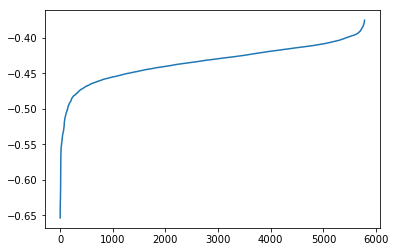

In [27]:
isf = IsolationForest(n_estimators=100, 
                      max_samples=0.5,
                      max_features=0.2)

isf = isf.fit(x)

y_score1 = isf.score_samples(x)

print(roc_auc_score(y_true=y, y_score=-y_score1))

y_score1 = np.sort(y_score1)

fig, ax = plt.subplots()
ax.plot(y_score1)

0.6327871349220571


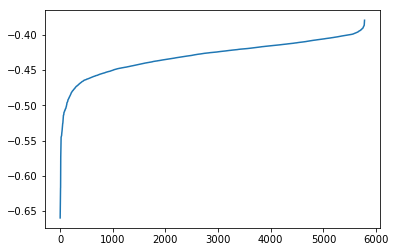

In [28]:
isf = IsolationForest(n_estimators=500, 
                      max_samples=0.8,
                      max_features=0.05)

isf = isf.fit(x)

y_score2 = isf.score_samples(x)

print(roc_auc_score(y_true=y, y_score=-y_score2))

y_score2 = np.sort(y_score2)

fig, ax = plt.subplots()
ax.plot(y_score2)

0.6148566565131697


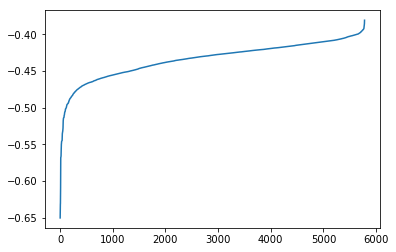

In [29]:
isf = IsolationForest(n_estimators=500, 
                      max_samples=0.5,
                      max_features=0.05)

isf = isf.fit(x)

y_score3 = isf.score_samples(x)

print(roc_auc_score(y_true=y, y_score=-y_score3))

y_score3 = np.sort(y_score3)

fig, ax = plt.subplots()
ax.plot(y_score3)

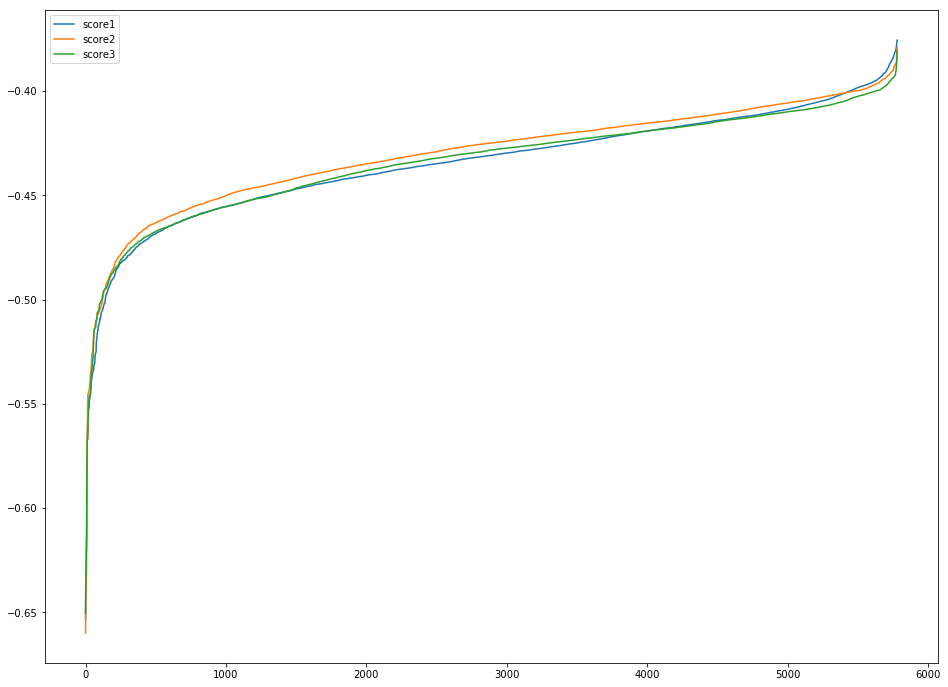

In [34]:
fig, ax = plt.subplots(figsize=(16,12))
ax.plot(y_score1, label='score1')
ax.plot(y_score2, label='score2')
ax.plot(y_score3, label='score3')
ax.legend()

In [35]:
auc(np.arange(0, y_score2.shape[0])/y_score2.shape[0], y_score2)

-0.4299584697144668

In [36]:
auc(np.arange(0, y_score2.shape[0])/y_score2.shape[0], y_score1)

-0.4342223700292114

In [37]:
auc(np.arange(0, y_score2.shape[0])/y_score2.shape[0], y_score3)

-0.4338045151710491

In [82]:
def isf_run(x, y, 
            n_estimators, 
            max_samples,
            max_features):
    
    isf = IsolationForest(n_estimators=n_estimators, 
                      max_samples=max_samples,
                      max_features=max_features)
    
    isf = isf.fit(x)

    y_score = isf.score_samples(x)

    #print(roc_auc_score(y_true=y, y_score=-y_score3))
    
    roc_auc = roc_auc_score(y_true=y, y_score=-y_score)

    y_score = np.sort(y_score)
    
    min_y = np.min(y_score)
    max_y = np.max(y_score)
    range_y = max_y - min_y
    
    y_score_n = (y_score - min_y)/range_y
    
    score_auc = auc(np.arange(0, y_score.shape[0])/y_score.shape[0], y_score_n)
    
    res = {'n_estimators':n_estimators,
          'max_samples':max_samples,
          'max_features':max_features,
          'roc_auc':roc_auc,
          'score_auc':score_auc,
          'scores':y_score,
          'scores_n':y_score_n}
    
    return res

In [50]:
isf_run(x, y, 100, 0.3, 0.1)

{'max_features': 0.1,
 'max_samples': 0.3,
 'n_estimators': 100,
 'roc_auc': 0.5598190288478767,
 'score_auc': 0.8087292209193353}

In [51]:
isf_run(x, y, 100, 0.5, 0.2)

{'max_features': 0.2,
 'max_samples': 0.5,
 'n_estimators': 100,
 'roc_auc': 0.5908663321985308,
 'score_auc': 0.8089415113331181}

In [52]:
isf_run(x, y, 100, 0.5, 0.3)

{'max_features': 0.3,
 'max_samples': 0.5,
 'n_estimators': 100,
 'roc_auc': 0.5775568894463359,
 'score_auc': 0.7995319983488756}

In [53]:
isf_run(x, y, 100, 0.8, 0.3)

{'max_features': 0.3,
 'max_samples': 0.8,
 'n_estimators': 100,
 'roc_auc': 0.5955447052499552,
 'score_auc': 0.8080734193023277}

In [78]:
params = [[100, 0.2, 0.1], [100, 0.3, 0.2], [100, 0.4, 0.3], [100, 0.5, 0.4],
         [500, 0.5, 0.05], [500, 0.8, 0.05]]

In [54]:
for p in params:
    res2 = isf_run(x, y, p[0], p[1], p[2])
    print(res2)

{'n_estimators': 100, 'max_samples': 0.3, 'max_features': 0.1, 'roc_auc': 0.5326375201576778, 'score_auc': 0.8045799245307634}
{'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.2, 'roc_auc': 0.5346058054112166, 'score_auc': 0.7848861418835502}
{'n_estimators': 100, 'max_samples': 0.5, 'max_features': 0.3, 'roc_auc': 0.5881652033685719, 'score_auc': 0.7884981826134871}
{'n_estimators': 100, 'max_samples': 0.8, 'max_features': 0.3, 'roc_auc': 0.5866905572478051, 'score_auc': 0.8045241523291207}


In [106]:
params = []
ntrees = [100, 500, 1000]
max_samp = [0.2, 0.5, 0.7, 0.9, 1.0]
max_feat = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]

for p1 in ntrees:
    for p2 in max_samp:
        for p3 in max_feat:
            params.append([p1, p2, p3])

In [109]:
res = Parallel(n_jobs=4)(delayed(isf_run)(x, y, p[0], p[1], p[2]) for p in params)

In [83]:
res3 = []
for p in params:
    res2 = isf_run(x, y, p[0], p[1], p[2])
    res3.append(res2)

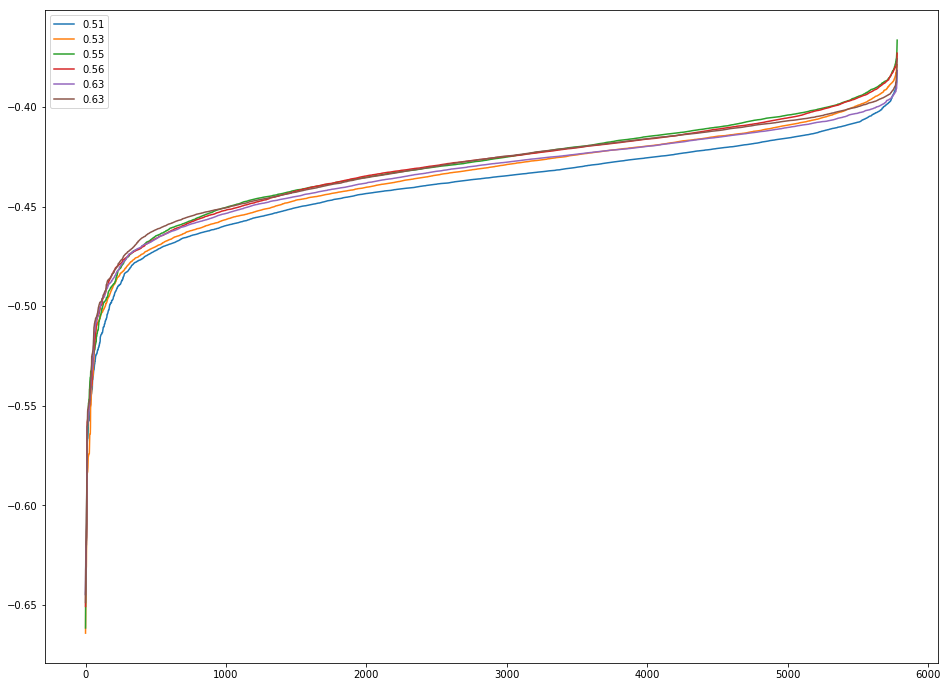

In [84]:
fig, ax = plt.subplots(figsize=(16,12))
for res in res3:
    rocauc = float(res['roc_auc'])
    ax.plot(res['scores'], label=f'{rocauc:.2f}')
    
ax.legend()

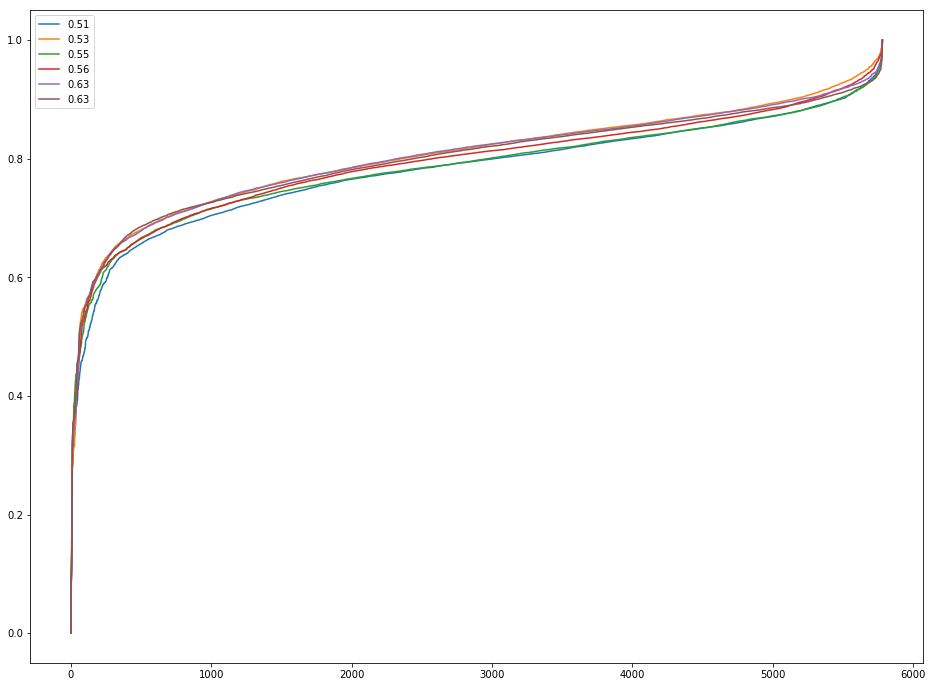

In [85]:
fig, ax = plt.subplots(figsize=(16,12))
for res in res3:
    rocauc = float(res['roc_auc'])
    ax.plot(res['scores_n'], label=f'{rocauc:.2f}')
    
ax.legend()

In [93]:
npts = 2500
for res in res3:
    print(res['roc_auc'], auc(np.arange(0, npts)/npts, res['scores_n'][0:npts]))

0.5067452069521591 0.6972674185659018
0.5345798244042286 0.7219325002933443
0.5450026876903781 0.7064562768861281
0.5578812040852894 0.7115737512848868
0.627377710087798 0.721505737313632
0.6341910051962014 0.7206278442076595


In [105]:
npts = 3
bkpt = 10
for res in res3:
    mean1 = np.mean(res['scores_n'][bkpt-npts:bkpt])
    mean2 = np.mean(res['scores_n'][bkpt:bkpt+npts])
    meandiff = mean2 - mean1
    #print(res['roc_auc'], auc(np.arange(0, npts)/npts, res['scores_n'][0:npts]))
    print(f"{float(res['roc_auc']):.2f}", f'{meandiff:.4f}')

0.51 0.1104
0.53 0.0740
0.55 0.0782
0.56 0.1259
0.63 0.1171
0.63 0.1247


In [111]:
roc_aucs = [r['roc_auc'] for r in res]

In [112]:
np.max(roc_aucs)

0.7314952517469987

In [113]:
res

[{'max_features': 0.01,
  'max_samples': 0.2,
  'n_estimators': 100,
  'roc_auc': 0.6994776921698621,
  'score_auc': 0.744272704808238,
  'scores': array([-0.58461611, -0.57843242, -0.57704301, ..., -0.43032989,
         -0.43022356, -0.4289738 ]),
  'scores_n': array([0.        , 0.03973016, 0.04865707, ..., 0.9912871 , 0.99197031,
         1.        ])},
 {'max_features': 0.05,
  'max_samples': 0.2,
  'n_estimators': 100,
  'roc_auc': 0.5979188317505824,
  'score_auc': 0.7677513912768974,
  'scores': array([-0.62954376, -0.6293077 , -0.62669151, ..., -0.380955  ,
         -0.38049961, -0.37906245]),
  'scores_n': array([0.00000000e+00, 9.42455743e-04, 1.13871085e-02, ...,
         9.92444373e-01, 9.94262431e-01, 1.00000000e+00])},
 {'max_features': 0.1,
  'max_samples': 0.2,
  'n_estimators': 100,
  'roc_auc': 0.5368473391865257,
  'score_auc': 0.7810468575980709,
  'scores': array([-0.66545888, -0.64840364, -0.64712631, ..., -0.38514412,
         -0.38095964, -0.3779847 ]),
  'score